# Why Tensorflow Probability? 

With all of the data science tools in the world, why do we need another one? <br>
<br>
What does Tensorflow Probability add to the mix?<br>
<br>
Let's take a look at the blog post that first [introduced Tensorflow Probability](https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html) to the world and ask ourselves: Are there any other tools that let me do this?

Now, let's look at a current problem: 
## How fast are covid-19 cases growing now? And what does that tell us about what we should do next?

In [7]:
#First import all the packages! All of them!!!
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

FILTERED_REGION_CODES = ['AS', 'GU', 'PR', 'VI', 'MP']

%config InlineBackend.figure_format = 'retina'

## Brief Math Lesson From Melinda
We've probably all heard about $R_0$, the replication number for a virus. <br>
The problem is, $R_0$ is how the virus replicates under "normal" circumstanes. It doesn't calculate the effect of quarantines and social distancing.<br>
<br>
### Less Brief Math Lesson From the Founder of Instagram
Kevin Systrom first published an article on Medium about how to estimate $R_t$, a "real time" version of $R_0$ that tells us how fast the virus is replicating __now__. [He and Mike Krieger have launched a website to track these numbers.](https://rt.live/)

In [4]:
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(9,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round()
    
    idx_start = np.searchsorted(smoothed, 10)
    print(idx_start)
    #smoothing and lagging means we don't start with the first day
    #of the series each time. Only analyze where we have "emough" cases
    smoothed = smoothed.iloc[idx_start:] #Find the first position with 10 cases
    original = cases.loc[smoothed.index] #Truncate all the series to that spot forward
    new_cases = new_cases.loc[smoothed.index]
    
    return new_cases, smoothed,original

In [5]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

print(states.index.min())
print(states.index.max())
print(states.shape)
states.head()

('AK', Timestamp('2020-03-06 00:00:00'))
('WY', Timestamp('2020-04-20 00:00:00'))
(2564,)


state  date      
AK     2020-03-06    0.0
       2020-03-07    0.0
       2020-03-08    0.0
       2020-03-09    0.0
       2020-03-10    0.0
Name: positive, dtype: float64

In [6]:
state_name="NY"
cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed_diff,cases = prepare_cases(cases)

0


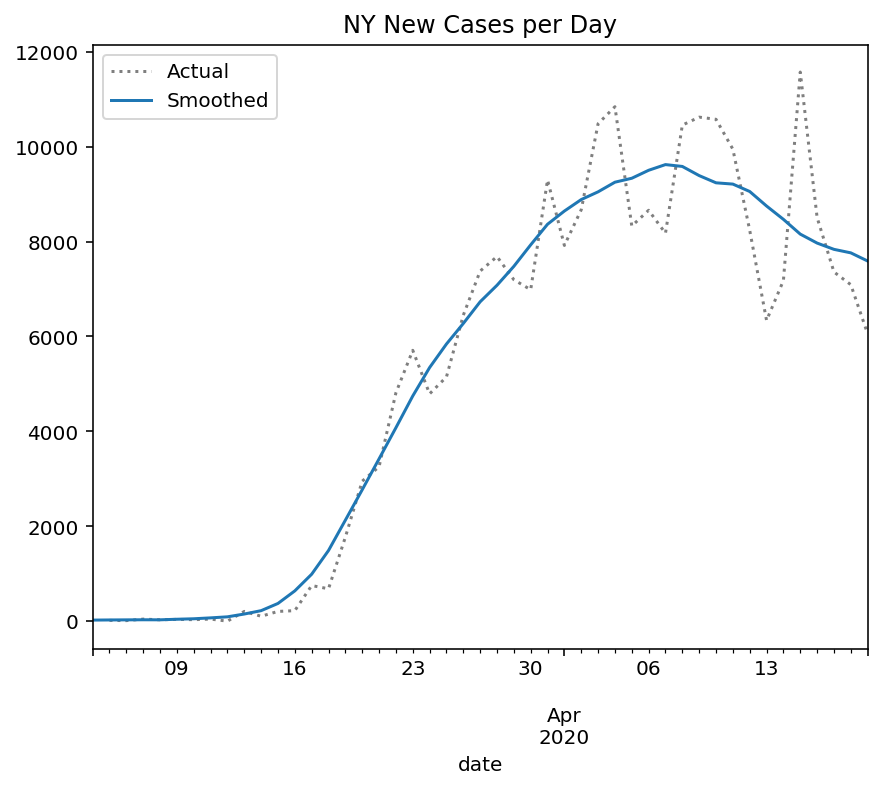

In [312]:
original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 400/72))

ax = smoothed_diff.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

Systrom's method requires to programmer to hand-calculate a likelihood function and then write an optimization function to find the maximume likelihood estimate for all of the time points.  <br>
The result is a brute-force algorithm that uses Bayesian methods to find the HDI (High Density Interval) for $R_t$ for every state at every time point. Basically, every observation that we have on covid cases growing from one day to the next gets its own parameter estimate. 
<br>
The code well-written, and worth a through read. [I invite you to peruse at your leisure.](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb)

### Wouldn't it be nice, though, if someone who knew a lot of math and a little programming could accomplish the same thing?

In [8]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [9]:
#Turn yesterday's smoothed value and today's new case count
#into tensors that 1) have the same length, and 2) Don't have NaN values
first_day=cases.index.min()
kt_1=tf.convert_to_tensor(smoothed_diff.drop(first_day),dtype=tf.float32)
kt=tf.convert_to_tensor(original.drop(first_day),dtype=tf.float32)

In [10]:
print(tf.shape(kt_1)==tf.shape(kt))
n_values=tf.shape(kt_1)
print(n_values)

tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([47], shape=(1,), dtype=int32)


# What the Heck is Gamma?
$\gamma$ is the serial interval--basically how long someone who's become infected stays infectious. For Systrom's algorithm to work, we need to have a good value for $\gamma$. Fortunately, there's a lot of study on this right now, and the covid literature estimates $\gamma$ as: 

In [11]:
GAMMA=1./7.

Implement Systrom's magic formula (originally calculated by [Bettencourt & Ribeiro](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) ) as a Python function. This turns the $R_t$ that we estimate into a parameter that calculates new cases.

In [12]:
def k_t_1_to_lambda(r_t,gamma=GAMMA):
    return kt_1*tf.exp(gamma*(r_t-1.))

This is our first Tensorflow Probability code! Don't wait for me to tell you what it does--Just read it. 

In [13]:
distribution_Rt=tfd.JointDistributionSequential(
    [tfd.Normal(2.,1.),
    lambda p : tfd.Independent(tfd.TruncatedNormal(tf.ones(46)*p,10.,0.3,5.)\
                              ,reinterpreted_batch_ndims=1),
    lambda r_t : tfd.Independent(tfd.Poisson(k_t_1_to_lambda(r_t))\
                    ,reinterpreted_batch_ndims=1)]
)

In [14]:
def build_model(n_time_points):
    return tfd.JointDistributionSequential(
    [tfd.Gamma(9.,2.),
    lambda p : tfd.Independent(tfd.TruncatedNormal(tf.ones(n_time_points)*p,3.,0.01,5.)\
                              ,reinterpreted_batch_ndims=1),
    lambda r_t : tfd.Independent(tfd.Poisson(k_t_1_to_lambda(r_t))\
                    ,reinterpreted_batch_ndims=1)
    ]
)

In [15]:
n_values

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([47], dtype=int32)>

In [16]:
distribution_Rt=build_model(n_values[0])

For a lot of complicated models, it's easier to think of them as a graph instead of an equation. The model selects an "overall" $p$, which is the mean of the truncated normal, then selects 46 $R_t$ values for the next distribution.  <br>
Why 46? Because that's the number of non-missing time points we have for New York. 

In [17]:
distribution_Rt.resolve_graph()

(('p', ()), ('r_t', ('p',)), ('x', ('r_t',)))

A Tensorflow Probability distribution is an object that knows how to do the following:
- Sample from the specified distribution
- Calculate the probability of a given value using that probability distribution.
- Calculate the log of the probability (everyone's favorite way to maximized a likelihood)
- Lots of other things not relevant here.

In [19]:
#Make sure the resulting model does what you think it does
s=distribution_Rt.sample()
#Sampling from the distribution should give you a tensor
#with with shape [1,45,45]
print(s)

[<tf.Tensor: shape=(), dtype=float32, numpy=5.8289695>, <tf.Tensor: shape=(47,), dtype=float32, numpy=
array([1.8418801 , 3.8454528 , 0.12686157, 1.7215056 , 2.369155  ,
       2.3294241 , 2.4588027 , 0.7568717 , 3.527668  , 4.6689873 ,
       4.900246  , 1.3765612 , 4.974904  , 4.6101866 , 4.0243387 ,
       3.7000294 , 2.3447306 , 4.4632936 , 2.8478475 , 2.5785248 ,
       1.5985227 , 1.1949067 , 3.9662569 , 4.289572  , 4.700345  ,
       4.551373  , 4.7200093 , 3.6896124 , 3.4510117 , 4.481064  ,
       3.3169494 , 3.2764459 , 3.0936706 , 4.973379  , 3.537133  ,
       2.9044797 , 0.586216  , 1.6603312 , 2.826703  , 4.5645113 ,
       3.9227595 , 4.64191   , 2.46754   , 1.9122927 , 2.4535604 ,
       3.7544374 , 3.468277  ], dtype=float32)>, <tf.Tensor: shape=(47,), dtype=float32, numpy=
array([   36.,    45.,    32.,    32.,    45.,    61.,    80.,   106.,
         216.,   398.,   650.,   702.,  1764.,  2416.,  3264.,  4176.,
        4044.,  6588.,  6097.,  6699.,  6328.,  6580., 1

In [415]:
#The tfd.Independent() addition tells Tensorflow Probability
#To sum (multiply) the result of the draws whenever distribution.log_prob(s) (distribution.prob(s))
#Is called.

In [20]:
s=distribution_Rt.sample()

In [21]:
distribution_Rt.log_prob([s[0],s[1],kt])

<tf.Tensor: shape=(), dtype=float32, numpy=-18262.684>

The log of the joint probability distribution is our objective function. We want to select the values of R_t that maximize that distribution

In [22]:
objective_function= lambda *x: distribution_Rt.log_prob(x+(kt,))
objective_function(s[0],s[1])

<tf.Tensor: shape=(), dtype=float32, numpy=-18262.684>

Get a random starting point for the MCMC chain

In [23]:
current_state = distribution_Rt.sample()[:-1]

In [24]:
current_state

[<tf.Tensor: shape=(), dtype=float32, numpy=2.7236528>,
 <tf.Tensor: shape=(47,), dtype=float32, numpy=
 array([0.6418047 , 3.772185  , 1.2847229 , 3.1023273 , 2.187024  ,
        2.1459875 , 3.471955  , 2.0969365 , 2.858327  , 4.339818  ,
        3.3353584 , 0.99497294, 2.249565  , 4.5022106 , 2.5098462 ,
        1.5025039 , 0.8953723 , 3.0435336 , 4.480586  , 1.1150246 ,
        1.8413144 , 0.15938926, 3.579297  , 1.3954914 , 0.98578596,
        3.613551  , 4.422342  , 4.513914  , 4.967845  , 3.6469169 ,
        4.455282  , 4.803959  , 0.9637418 , 1.7538133 , 4.2598867 ,
        1.1024345 , 4.947606  , 0.92140186, 2.707623  , 3.302036  ,
        0.49416804, 0.5887599 , 1.1677895 , 2.702489  , 2.3025045 ,
        4.705055  , 4.325835  ], dtype=float32)>]

In [25]:
objective_function(*current_state)

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=objective_function,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=current_state,
          kernel=adaptive_hmc,
          trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
    return samples, is_accepted
  
#   sample_mean = tf.reduce_mean(samples)
#   sample_stddev = tf.math.reduce_std(samples)
#   is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
#   return sample_mean, sample_stddev, is_accepted

samples,is_accepted = run_chain()

print(tfp.stats.percentile(samples[0],95))
print(tfp.stats.percentile(samples[0],5))

upper_95=tfp.stats.percentile(samples[1],95,axis=[0])
lower_5=tfp.stats.percentile(samples[1],5,axis=[0])
mean_samples=tf.reduce_mean(samples[1],axis=0)

result=pd.DataFrame({"upper_95":upper_95.numpy()\
                    ,"lower_5":lower_5.numpy()\
                     ,"Mean":mean_samples.numpy()},index=original.drop(first_day).index)

tf.Tensor(2.500676, shape=(), dtype=float32)
tf.Tensor(1.8857459, shape=(), dtype=float32)


In [26]:
upper_95

<tf.Tensor: shape=(47,), dtype=float32, numpy=
array([0.504028  , 3.6428695 , 1.3976716 , 3.303656  , 2.0565903 ,
       2.320711  , 3.703775  , 1.7390108 , 3.0232134 , 3.5686858 ,
       2.7039897 , 0.0722723 , 1.4455681 , 1.3889766 , 1.1316363 ,
       1.5746413 , 0.8954978 , 2.4170618 , 2.5233014 , 0.42489702,
       0.33212194, 1.2707785 , 1.7521949 , 1.6834853 , 0.9200562 ,
       0.3427656 , 1.8746356 , 0.5136563 , 0.9712741 , 2.143942  ,
       2.2278683 , 0.36485788, 0.48581907, 0.07994442, 1.7409556 ,
       1.9919093 , 2.1306396 , 1.6242083 , 0.47886577, 0.02886332,
       0.12590902, 3.5348787 , 1.7365143 , 0.9771673 , 0.9585797 ,
       0.38394397, 0.03392764], dtype=float32)>

In [27]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['Mean'].index.get_level_values('date')
    values = result['Mean'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.2,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['lower_5'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['upper_95'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(-0.1, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

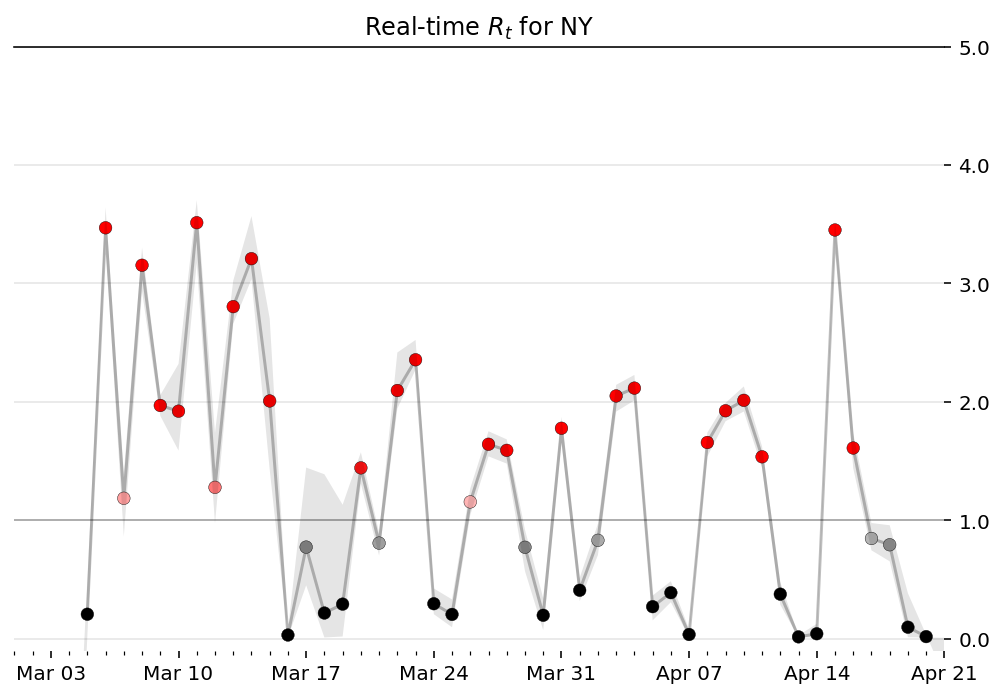

In [28]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

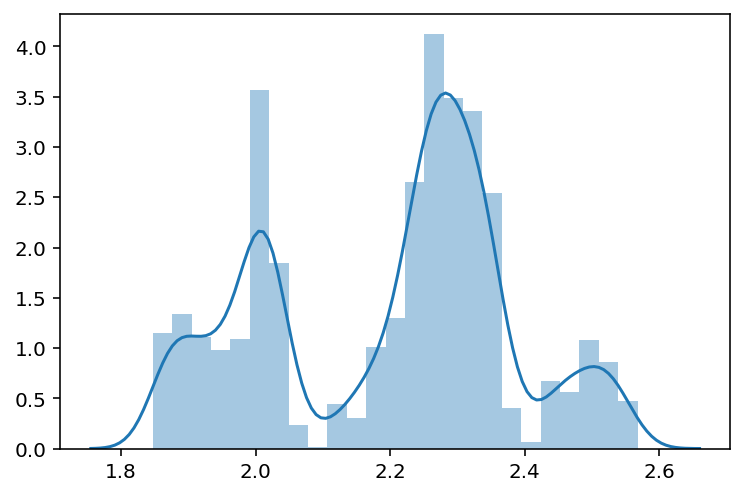

In [32]:
sns.distplot(samples[0])

# Caveats and Gotchas

## You still need to know some math
Actually, you need to know a lot of math. <br>
## You still need to know some programming
If you're already a Tensorflow nerd, this will be easier. If you're a Python programmer who doesn't know Tensorflow, it will be ok. If you've never used Python or Tensorflow, it will take some time to get up to speed. <br>

# This is Easily the Most Exciting Software I've Ever Seen

## You can stand this up on a cloud server and just run with it. 
No coding it twice, no futzing around in another language for months and then shifting your code over to C++ or Python to make it run at scale. TFP is GPU-enabled out of the box. 
## It interfaces with Tensorflow. 
The functions that feed into that distribution can be anything: Keras layers, the output from a giant neural network, the sky is the limit. 

# Useful Packages that Will Save You Time<br>
GLM Package:<br>
https://www.tensorflow.org/probability/api_docs/python/tfp/glm/ExponentialFamily <br>
Structural Time Series<br>
https://www.tensorflow.org/probability/api_docs/python/tfp/sts/LinearRegression <br>
<br>
Linear Mixed Effect Models<br>
https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Models.ipynb#scrollTo=QQxq9acQ9MpO<br>
And if you're really excited about learning more: <br>
https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/